In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#Data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import datetime
import math
import statistics
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from itertools import product
from math import sqrt
import json
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import TransformerMixin #gives fit_transform method for free

#Models
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Dropout,Reshape
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
from sklearn.feature_selection import RFE

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
np.random_seed=42

In [3]:
sample=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

In [4]:
#Lets first split our train dataset into the training portions and validation portions
X = train.drop(columns=['Transported'])
y = train['Transported']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Shows number of rows in X_train
X_train.shape[0]

6085

In [6]:
#Next,lets have a look at our data

def data_sum(dataframe):
    nulls=[]
    count=[]
    unique=[]
    null_percentage=[]
    dtype=[]

    for col in dataframe.columns:
        nulls.append(dataframe[col].isnull().sum())
        count.append(dataframe[col].count())
        unique.append(dataframe[col].nunique())
        total_rows=dataframe.shape[0]
        null_percentage.append(dataframe[col].isnull().sum()*100/total_rows)
        dtype.append(dataframe[col].dtype)
    
    summary=pd.DataFrame({
        'Column': dataframe.columns,
        'Nulls': nulls,
        'Non-Null Count': count,
        'Unique Values': unique,
        'Null Percentage': null_percentage,
        'Data Type': dtype
    })

    return(summary)

X_train_summary=data_sum(X_train)
print(X_train_summary)

          Column  Nulls  Non-Null Count  Unique Values  Null Percentage  \
0    PassengerId      0            6085           6085         0.000000   
1     HomePlanet    140            5945              3         2.300740   
2      CryoSleep    154            5931              2         2.530813   
3          Cabin    142            5943           4860         2.333607   
4    Destination    122            5963              3         2.004930   
5            Age    129            5956             80         2.119967   
6            VIP    153            5932              2         2.514380   
7    RoomService    114            5971           1026         1.873459   
8      FoodCourt    122            5963           1216         2.004930   
9   ShoppingMall    146            5939            891         2.399343   
10           Spa    122            5963           1077         2.004930   
11        VRDeck    129            5956           1050         2.119967   
12          Name    138  

In [7]:
#Lets first drop some colums we wont be using
X_train=X_train.drop(columns=['PassengerId','Name'])
X_valid=X_valid.drop(columns=['PassengerId','Name'])
test=test.drop(columns=['PassengerId','Name'])






In [8]:
# X_train['TotalSpending'] = X_train[['FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].sum()

In [9]:
X_train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
3032,Europa,False,B/120/S,TRAPPIST-1e,43.0,False,0.0,1440.0,0.0,85.0,150.0
7757,Europa,True,C/273/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0
1795,Earth,False,G/300/S,TRAPPIST-1e,46.0,False,8.0,652.0,0.0,5.0,90.0
1702,Earth,False,F/346/S,TRAPPIST-1e,33.0,False,0.0,763.0,8.0,2.0,30.0
6634,Earth,False,F/1334/S,55 Cancri e,24.0,False,0.0,58.0,618.0,0.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...
5734,Earth,NaN,G/988/S,TRAPPIST-1e,18.0,False,14.0,2.0,144.0,610.0,0.0
5191,Mars,False,F/1063/S,TRAPPIST-1e,50.0,NaN,690.0,0.0,30.0,762.0,428.0
5390,Earth,False,F/1194/P,PSO J318.5-22,22.0,False,158.0,0.0,476.0,0.0,26.0
860,Mars,False,F/191/P,TRAPPIST-1e,34.0,False,379.0,0.0,1626.0,0.0,0.0


In [10]:
X_train.corr()

/tmp/ipykernel_32/131534602.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train.corr()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.063455,0.131770,0.035980,0.127165,0.100089
RoomService,0.063455,1.000000,-0.016009,0.042314,0.003144,-0.018663
FoodCourt,0.131770,-0.016009,1.000000,-0.008833,0.209270,0.242087
ShoppingMall,0.035980,0.042314,-0.008833,1.000000,0.022235,0.002684
Spa,0.127165,0.003144,0.209270,0.022235,1.000000,0.173287
VRDeck,0.100089,-0.018663,0.242087,0.002684,0.173287,1.000000


First lets split into deck num side 

In [11]:
X_train[["Deck","Num","Side"]]=X_train["Cabin"].str.split("/",expand = True)


In [12]:
X_valid[["Deck","Num","Side"]]=X_valid["Cabin"].str.split("/",expand = True)

In [13]:
test[["Deck","Num","Side"]]=test["Cabin"].str.split("/",expand = True)

In [14]:
X_train.drop(columns = ['Cabin'], inplace = True)

In [15]:
X_valid.drop(columns = ['Cabin'], inplace = True)

In [16]:
test.drop(columns = ['Cabin'], inplace = True)

In [17]:
#Now im trying to impute using interpolation
# Age & Amenities has a relationship. The older, the more spending.
X_train[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']] = X_train[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].interpolate(method='linear')

In [18]:
#Now im trying to impute using interpolation
# Age & Amenities has a relationship. The older, the more spending.
test[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']] = test[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].interpolate(method='linear')

In [19]:
#Now im trying to impute using interpolation
# Age & Amenities has a relationship. The older, the more spending.
X_valid[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']] = X_valid[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].interpolate(method='linear')

In [20]:
#lets see how the dataframe is like now
X_train_2_summary=data_sum(X_train)
X_train_2_summary

,Column,Nulls,Non-Null Count,Unique Values,Null Percentage,Data Type
0,HomePlanet,140,5945,3,2.300740,object
1,CryoSleep,154,5931,2,2.530813,object
2,Destination,122,5963,3,2.004930,object
3,Age,0,6085,114,0.000000,float64
4,VIP,153,5932,2,2.514380,object
5,RoomService,0,6085,1060,0.000000,float64
6,FoodCourt,0,6085,1266,0.000000,float64
7,ShoppingMall,0,6085,938,0.000000,float64
8,Spa,0,6085,1114,0.000000,float64
9,VRDeck,0,6085,1101,0.000000,float64


Looks like we have completed the imputing for numerical features now lets work on the categorical features.



<!--  --> from sklearn.impute import SimpleImputer. Constant strategy is better for one-hot encoding


In [21]:
categorical = X_train.dtypes == 'object'
categorical

HomePlanet       True
CryoSleep        True
Destination      True
Age             False
VIP              True
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Deck             True
Num              True
Side             True
dtype: bool

Look at the columns with categorical data.
Starting from HomePlanet.

Aus help to put some imputation for Arden
Arden - Above
Austin - Below

In [22]:
#Created a new feature
X_train["TotalSpending"]=X_train[["RoomService","Spa","FoodCourt","VRDeck",'ShoppingMall']].sum(axis=1)
X_valid["TotalSpending"]=X_valid[["RoomService","Spa","FoodCourt","VRDeck",'ShoppingMall']].sum(axis=1)
test["TotalSpending"]=test[["RoomService","Spa","FoodCourt","VRDeck",'ShoppingMall']].sum(axis=1)

Lets impute HomePlanet

In [23]:
#For rows where ["Destination"]=="PSO J318.5-22",let the rows with missing values in ["HomePlanet"] be imputed with "Earth"
X_train.loc[X_train["Destination"]=="PSO J318.5-22","HomePlanet"] = X_train.loc[X_train["Destination"]=="PSO J318.5-22","HomePlanet"].fillna("Earth")
#For rows where ["Destination"]=="55 Cancri e",let the rows with missing values in ["HomePlanet"] be imputed with "Europa"
X_train.loc[X_train["Destination"]=="55 Cancri e","HomePlanet"]=X_train.loc[X_train["Destination"]=="55 Cancri e","HomePlanet"].fillna("Europa")
#For rows where ["Destination"]=="TRAPPIST-1e",let the rows with missing values in ["HomePlanet"] be imputed with "Earth"
X_train.loc[X_train["Destination"]=="TRAPPIST-1e","HomePlanet"]=X_train.loc[X_train["Destination"]=="TRAPPIST-1e","HomePlanet"].fillna("Earth")
X_train.loc[X_train['Deck']=='A','HomePlanet']=X_train.loc[X_train['Deck']=='A','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='B','HomePlanet']=X_train.loc[X_train['Deck']=='B','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='C','HomePlanet']=X_train.loc[X_train['Deck']=='C','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='T','HomePlanet']=X_train.loc[X_train['Deck']=='T','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='G','HomePlanet']=X_train.loc[X_train['Deck']=='G','HomePlanet'].fillna("Earth")
X_train.loc[X_train['Destination'] == 'TRAPPIST-1e', 'HomePlanet'] = X_train.loc[X_train['Destination'] == 'TRAPPIST-1e', 'HomePlanet'].fillna('Earth')
X_train['HomePlanet']=X_train['HomePlanet'].fillna('Earth')

X_valid.loc[X_valid["Destination"]=="PSO J318.5-22","HomePlanet"]=X_valid.loc[X_valid["Destination"]=="PSO J318.5-22","HomePlanet"].fillna("Earth")
test.loc[test["Destination"]=="PSO J318.5-22","HomePlanet"]=test.loc[test["Destination"]=="PSO J318.5-22","HomePlanet"].fillna("Earth")
X_valid.loc[X_valid["Destination"]=="55 Cancri e","HomePlanet"]=X_valid.loc[X_valid["Destination"]=="55 Cancri e","HomePlanet"].fillna("Europa")
test.loc[test["Destination"]=="55 Cancri e","HomePlanet"]=test.loc[test["Destination"]=="55 Cancri e","HomePlanet"].fillna("Europa")
X_valid.loc[X_valid["Destination"]=="TRAPPIST-1e","HomePlanet"]=X_valid.loc[X_valid["Destination"]=="TRAPPIST-1e","HomePlanet"].fillna("Earth")
test.loc[test["Destination"]=="TRAPPIST-1e","HomePlanet"]=test.loc[test["Destination"]=="TRAPPIST-1e","HomePlanet"].fillna("Earth")
X_valid.loc[X_valid['Deck']=='A','HomePlanet']=X_valid.loc[X_valid['Deck']=='A','HomePlanet'].fillna("Europa")
X_valid.loc[X_valid['Deck']=='B','HomePlanet']=X_valid.loc[X_valid['Deck']=='B','HomePlanet'].fillna("Europa")
X_valid.loc[X_valid['Deck']=='C','HomePlanet']=X_valid.loc[X_valid['Deck']=='C','HomePlanet'].fillna("Europa")
X_valid.loc[X_valid['Deck']=='T','HomePlanet']=X_valid.loc[X_valid['Deck']=='T','HomePlanet'].fillna("Europa")
X_valid.loc[X_valid['Deck']=='G','HomePlanet']=X_valid.loc[X_valid['Deck']=='G','HomePlanet'].fillna("Earth")
X_valid.loc[X_valid['Destination'] == 'TRAPPIST-1e', 'HomePlanet'] = X_valid.loc[X_valid['Destination'] == 'TRAPPIST-1e', 'HomePlanet'].fillna('Earth')
X_valid['HomePlanet']=X_valid['HomePlanet'].fillna('Earth')

test.loc[test['Deck']=='A','HomePlanet']=test.loc[test['Deck']=='A','HomePlanet'].fillna("Europa")
test.loc[test['Deck']=='B','HomePlanet']=test.loc[test['Deck']=='B','HomePlanet'].fillna("Europa")
test.loc[test['Deck']=='C','HomePlanet']=test.loc[test['Deck']=='C','HomePlanet'].fillna("Europa")
test.loc[test['Deck']=='T','HomePlanet']=test.loc[test['Deck']=='T','HomePlanet'].fillna("Europa")
test.loc[test['Deck']=='G','HomePlanet']=test.loc[test['Deck']=='G','HomePlanet'].fillna("Earth")
test.loc[test['Destination'] == 'TRAPPIST-1e', 'HomePlanet'] = test.loc[test['Destination'] == 'TRAPPIST-1e', 'HomePlanet'].fillna('Earth')
test['HomePlanet']=test['HomePlanet'].fillna('Earth')



Lets impute CryoSleep

In [24]:
X_train.loc[X_train["TotalSpending"]>=5000,"CryoSleep"]=X_train.loc[X_train["TotalSpending"]>=5000,"CryoSleep"].fillna(False)
X_train.loc[X_train["TotalSpending"]==0,"CryoSleep"]=X_train.loc[X_train["TotalSpending"]==0,"CryoSleep"].fillna(True)
X_train["CryoSleep"]=X_train["CryoSleep"].fillna(False)

X_valid.loc[X_valid["TotalSpending"]>=5000,"CryoSleep"]=X_valid.loc[X_valid["TotalSpending"]>=5000,"CryoSleep"].fillna(False)
X_valid.loc[X_valid["TotalSpending"]==0,"CryoSleep"]=X_valid.loc[X_valid["TotalSpending"]==0,"CryoSleep"].fillna(True)
X_valid["CryoSleep"]=X_valid["CryoSleep"].fillna(False)

test.loc[test["TotalSpending"]>=5000,"CryoSleep"]=test.loc[test["TotalSpending"]>=5000,"CryoSleep"].fillna(False)
test.loc[test["TotalSpending"]==0,"CryoSleep"]=test.loc[test["TotalSpending"]==0,"CryoSleep"].fillna(True)
test["CryoSleep"]=test["CryoSleep"].fillna(False)

Lets impute Destination

In [25]:
X_train.loc[X_train['VIP'] == 'FALSE','Destination'] = X_train.loc[X_train['VIP'] == 'FALSE','Destination'].fillna('TRAPPIST-1e')
X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'ffill')
X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'bfill')
X_train.loc[X_train['HomePlanet'] == 'Europa', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Europa', 'Destination'].fillna('55 Cancri e')
X_train.loc[X_train['HomePlanet'] == 'Mars', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Mars', 'Destination'].fillna('TRAPPIST-1e')
X_train.loc[X_train['HomePlanet'] == 'Earth','Destination'] = X_train.loc[X_train['HomePlanet'] == 'Earth','Destination'].fillna('TRAPPIST-1e')
X_train.loc[X_train['VIP'] == False, 'Destination'] = X_train.loc[X_train['VIP'] == False, 'Destination'].fillna('TRAPPIST-1e')
X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'].fillna('TRAPPIST-1e')

X_valid.loc[X_valid['VIP'] == 'FALSE','Destination'] = X_valid.loc[X_valid['VIP'] == 'FALSE','Destination'].fillna('TRAPPIST-1e')
X_valid.loc[X_valid['HomePlanet'] == 'Earth', 'Destination'] = X_valid.loc[X_valid['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'ffill')
X_valid.loc[X_valid['HomePlanet'] == 'Earth', 'Destination'] = X_valid.loc[X_valid['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'bfill')
X_valid.loc[X_valid['HomePlanet'] == 'Europa', 'Destination'] = X_valid.loc[X_valid['HomePlanet'] == 'Europa', 'Destination'].fillna('55 Cancri e')
X_valid.loc[X_valid['HomePlanet'] == 'Mars', 'Destination'] = X_valid.loc[X_valid['HomePlanet'] == 'Mars', 'Destination'].fillna('TRAPPIST-1e')
X_valid.loc[X_valid['HomePlanet'] == 'Earth','Destination'] = X_valid.loc[X_valid['HomePlanet'] == 'Earth','Destination'].fillna('TRAPPIST-1e')
X_valid.loc[X_valid['VIP'] == False, 'Destination'] = X_valid.loc[X_valid['VIP'] == False, 'Destination'].fillna('TRAPPIST-1e')
X_valid.loc[X_valid['HomePlanet'] == 'Earth', 'Destination'] = X_valid.loc[X_valid['HomePlanet'] == 'Earth', 'Destination'].fillna('TRAPPIST-1e')

test.loc[test['VIP'] == 'FALSE','Destination'] = test.loc[test['VIP'] == 'FALSE','Destination'].fillna('TRAPPIST-1e')
test.loc[test['HomePlanet'] == 'Earth', 'Destination'] = test.loc[test['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'ffill')
test.loc[test['HomePlanet'] == 'Earth', 'Destination'] = test.loc[test['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'bfill')
test.loc[test['HomePlanet'] == 'Europa', 'Destination'] = test.loc[test['HomePlanet'] == 'Europa', 'Destination'].fillna('55 Cancri e')
test.loc[test['HomePlanet'] == 'Mars', 'Destination'] = test.loc[test['HomePlanet'] == 'Mars', 'Destination'].fillna('TRAPPIST-1e')
test.loc[test['HomePlanet'] == 'Earth','Destination'] = test.loc[test['HomePlanet'] == 'Earth','Destination'].fillna('TRAPPIST-1e')
test.loc[test['VIP'] == False, 'Destination'] = test.loc[test['VIP'] == False, 'Destination'].fillna('TRAPPIST-1e')
test.loc[test['HomePlanet'] == 'Earth', 'Destination'] = test.loc[test['HomePlanet'] == 'Earth', 'Destination'].fillna('TRAPPIST-1e')

Lets impute VIP

In [26]:
X_train.loc[X_train['TotalSpending'] >= 5000, 'VIP'] = X_train.loc[X_train['TotalSpending'] >= 5000, 'VIP'].fillna(True)
X_train.loc[X_train['TotalSpending'] < 5000, 'VIP'] = X_train.loc[X_train['TotalSpending'] < 5000, 'VIP'].fillna(False)

X_valid.loc[X_valid['TotalSpending'] >= 5000, 'VIP'] = X_valid.loc[X_valid['TotalSpending'] >= 5000, 'VIP'].fillna(True)
X_valid.loc[X_valid['TotalSpending'] < 5000, 'VIP'] = X_valid.loc[X_valid['TotalSpending'] < 5000, 'VIP'].fillna(False)

test.loc[test['TotalSpending'] >= 5000, 'VIP'] = test.loc[test['TotalSpending'] >= 5000, 'VIP'].fillna(True)
test.loc[test['TotalSpending'] < 5000, 'VIP'] = test.loc[test['TotalSpending'] < 5000, 'VIP'].fillna(False)

Lets impute Deck

In [27]:
#Deck has a uneven distribution with deck G and F having a far larger value then the other decks. Lets just impute all nulls  to be F
X_train['Deck']=X_train['Deck'].fillna('F')
X_valid['Deck']=X_valid['Deck'].fillna('F')
test['Deck']=test['Deck'].fillna('F')

Lets  change datatype then impute Num

In [28]:
#Convert ['Num'] to numerical feature
X_train['Num'] = X_train['Num'].str.replace(' ', '').astype(float)
print(f"There are initially {X_train['Num'].isna().sum()} nulls")
#Num has too much unique values and we cant do simple imputation because each unique value has such a low count that setting all 72 nulls to that value will skew the results so we just randomly impute the nulls using the existing values 
num_values = X_train['Num'].dropna().values

X_valid['Num'] = X_valid['Num'].str.replace(' ', '').astype(float)
print(f"There are initially {X_valid['Num'].isna().sum()} nulls")
#Num has too much unique values and we cant do simple imputation because each unique value has such a low count that setting all 72 nulls to that value will skew the results so we just randomly impute the nulls using the existing values 
num_values = X_valid['Num'].dropna().values

test['Num'] = test['Num'].str.replace(' ', '').astype(float)
print(f"There are initially {test['Num'].isna().sum()} nulls")
#Num has too much unique values and we cant do simple imputation because each unique value has such a low count that setting all 72 nulls to that value will skew the results so we just randomly impute the nulls using the existing values 
num_values = test['Num'].dropna().values


# Shuffle non-missing values multiple times
num_shuffled = num_values.copy()  # Make a copy to shuffle multiple times
np.random.shuffle(num_shuffled)
num_shuffled=pd.Series(num_shuffled)

non_numeric_values = num_shuffled[np.isnan(num_shuffled)]
if non_numeric_values.size == 0:
    print("All values in num_shuffled are numerical.")
else:
    print(f"There are {non_numeric_values.size} non-numeric values in num_shuffled.")
num_unique_values = np.unique(num_shuffled).size
print(f"There are {num_unique_values} unique values in the num_shuffled array.")


# Fill missing values with the shuffled values
X_train['Num']=X_train['Num'].fillna(num_shuffled)
print(f"Now there are {X_train['Num'].isna().sum()} nulls")

X_valid['Num']=X_valid['Num'].fillna(num_shuffled)

test['Num']=test['Num'].fillna(num_shuffled)
                                  
#for some reason the number of nulls dropped to 34 but wont drop further, im gonna impute the last 34 nulls with the most frequent value for now until I can solve why
X_train['Num']=X_train['Num'].fillna(82)
print(f"Now there are {X_train['Num'].isna().sum()} nulls")

X_valid['Num']=X_valid['Num'].fillna(82)
print(f"Now there are {X_valid['Num'].isna().sum()} nulls")

test['Num']=test['Num'].fillna(82)
print(f"Now there are {test['Num'].isna().sum()} nulls")
    



There are initially 142 nulls
There are initially 57 nulls
There are initially 100 nulls
All values in num_shuffled are numerical.
There are 1505 unique values in the num_shuffled array.
Now there are 60 nulls
Now there are 0 nulls
Now there are 0 nulls
Now there are 0 nulls


Lets impute side

In [29]:
#For Side, they are almost equal and rightfully so, lets just impute the nulls equally
for value in ['S','P']:
    null_indices = X_train[X_train['Side'].isnull()].sample(71).index
    X_train.loc[null_indices, 'Side'] = value
    
for value in ['S','P']:
    null_indices = X_valid[X_valid['Side'].isnull()].sample(28).index
    X_valid.loc[null_indices, 'Side'] = value
X_valid.loc[X_valid[X_valid["Side"].isna()].index,"Side"]="S"
    
for value in ['S','P']:
    null_indices = test[test['Side'].isnull()].sample(50).index
    test.loc[null_indices, 'Side'] = value    

In [30]:
X_valid.loc[X_valid[X_valid["Side"].isna()].index,"Side"]="S"

In [31]:
X_train_3_summary=data_sum(X_valid)
X_train_3_summary

,Column,Nulls,Non-Null Count,Unique Values,Null Percentage,Data Type
0,HomePlanet,0,2608,3,0.0,object
1,CryoSleep,0,2608,2,0.0,bool
2,Destination,0,2608,3,0.0,object
3,Age,0,2608,94,0.0,float64
4,VIP,0,2608,2,0.0,object
5,RoomService,0,2608,586,0.0,float64
6,FoodCourt,0,2608,602,0.0,float64
7,ShoppingMall,0,2608,535,0.0,float64
8,Spa,0,2608,585,0.0,float64
9,VRDeck,0,2608,557,0.0,float64


Imputation complete
<br>
Now lets encode
<br>
Cardinality:
<br>
Low: 2-5
<br>
Moderate: 6-46
<br>
High: 50 and above

HomePlanet:Label Encoding
<br>
CryoSleep:Label Encoding
<br>
Destination:Label Encoding
<br>
VIP:Label Encoding
<br>
Deck:OHE
<br>
Side:Label Encoding
<br>
Remaining numerical features:Standardization

In [32]:

class MyLabelEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelEncoder(*args, **kwargs)
    def fit(self, x, y=0):
        print(f" The shape of the fitted is {x.shape}")
        print(f" The shape of the y is {y}")
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        print(x.shape)
        return self.encoder.transform(x)
    def fit_transform(self, x, y=0):
        #print(f" The shape of the fitted is {x.shape}")
        #x is a dataframe
        columns=x.columns
        transformed_features=[]
        for column in columns:
            #print(f" The column is {column}")
            feature_column = x[column]
            #print(f" Each column has a shape of {feature_column.shape}")
            self.encoder.fit(feature_column)
            new_feature_column=self.encoder.transform(feature_column)
            transformed_features.append(new_feature_column)
        transformed_features=np.transpose(transformed_features)
        return transformed_features
        
        
            
            
            
            
        
            
        

In [33]:
#print(X_train['Deck'].value_counts())
#print(X_valid['Deck'].value_counts())
#print(test['Deck'].value_counts())

l_c_c_f=["HomePlanet", "CryoSleep", "Destination", "VIP", "Side"]
m_c_c_f=['Deck']
n_f=X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()



# Create transformers for categorical features
l_c_categorical_transformer = Pipeline(steps=[
    ('encoder', MyLabelEncoder())  
])

m_c_categorical_transformer = Pipeline(steps=[
    ('encoder',OneHotEncoder(handle_unknown='ignore'))  
])


# Create transformers for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, n_f),
        ('m_c_cat', m_c_categorical_transformer, m_c_c_f),
        ('l_c_cat', l_c_categorical_transformer, l_c_c_f)
    ])

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the preprocessing pipeline to your data
encoded_data_X_train = preprocessing_pipeline.fit_transform(X_train)
print(encoded_data_X_train.shape)
columns=np.concatenate((n_f,['A','B','C','D','E','F','G','T'] , l_c_c_f))
# Convert the transformed data back to a DataFrame
X_train_encoded = pd.DataFrame(encoded_data_X_train,columns=columns)

#Lets fit the pipeline to X_valid and test too
encoded_data_X_valid = preprocessing_pipeline.fit_transform(X_valid)
print(encoded_data_X_valid.shape)
columns=np.concatenate((n_f,['A','B','C','D','E','F','G',] , l_c_c_f))
X_valid = pd.DataFrame(encoded_data_X_valid,columns=columns)
X_valid['T']=0
# Get the column you want to move
column_to_move = X_valid.pop('T')
# Insert the column in the 16th position
X_valid.insert(15, 'T', column_to_move)
encoded_data_test = preprocessing_pipeline.fit_transform(test)
columns=np.concatenate((n_f,['A','B','C','D','E','F','G','T'] , l_c_c_f))
test = pd.DataFrame(encoded_data_test,columns=columns)

(6085, 21)
(2608, 20)


In [34]:
X_train_encoded

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,TotalSpending,A,B,...,D,E,F,G,T,HomePlanet,CryoSleep,Destination,VIP,Side
0,0.979253,-0.331025,0.600237,-0.279532,-0.205590,-0.135225,-0.939877,0.061536,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
1,-0.406069,-0.331025,-0.294516,-0.279532,-0.281281,-0.262945,-0.640617,-0.525302,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
2,1.187051,-0.319384,0.110608,-0.279532,-0.276829,-0.186313,-0.587807,-0.260787,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0
3,0.286592,-0.331025,0.179579,-0.266621,-0.279500,-0.237401,-0.497834,-0.243970,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
4,-0.336803,-0.331025,-0.258477,0.717841,-0.281281,-0.228035,1.434638,-0.274101,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6080,-0.752399,-0.310652,-0.293273,-0.047135,0.261912,-0.262945,0.757882,-0.255532,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0
6081,1.464115,0.673070,-0.294516,-0.231116,0.397265,0.101483,0.904577,0.143868,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0
6082,-0.475335,-0.101102,-0.294516,0.488671,-0.281281,-0.240807,1.160806,-0.294071,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6083,0.355858,0.220499,-0.294516,2.344624,-0.281281,-0.262945,-0.801005,0.177151,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0


Fantastic we are now done with encoding so lets move on to polynomial features, thing is we dont know how many degrees is the most optimal so lets just create multiple sets of different degrees and see which degree performs the best

New number of features are 20
New number of features are 19
New number of features are 18
New number of features are 17
New number of features are 16
New number of features are 15
New number of features are 14
New number of features are 13
New number of features are 12
New number of features are 11
New number of features are 10
New number of features are 9
New number of features are 8
New number of features are 7
New number of features are 6
New number of features are 5
New number of features are 4
New number of features are 3
New number of features are 2
New number of features are 1


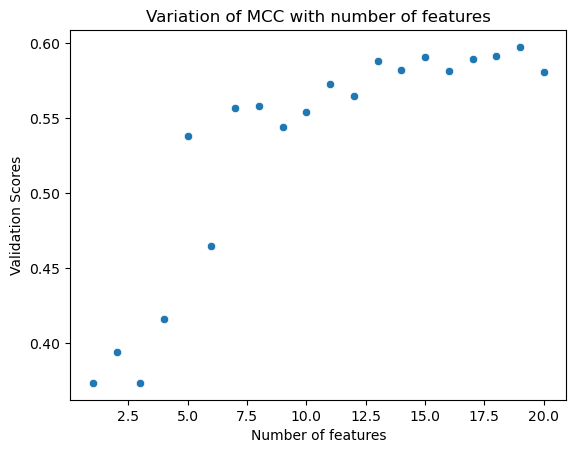

Degree 1 done
New number of features are 251
New number of features are 250
New number of features are 249
New number of features are 248
New number of features are 247
New number of features are 246
New number of features are 245
New number of features are 244
New number of features are 243
New number of features are 242
New number of features are 241
New number of features are 240
New number of features are 239
New number of features are 238
New number of features are 237
New number of features are 236
New number of features are 235
New number of features are 234
New number of features are 233
New number of features are 232
New number of features are 231
New number of features are 230
New number of features are 229
New number of features are 228
New number of features are 227
New number of features are 226
New number of features are 225
New number of features are 224
New number of features are 223
New number of features are 222
New number of features are 221
New number of features ar

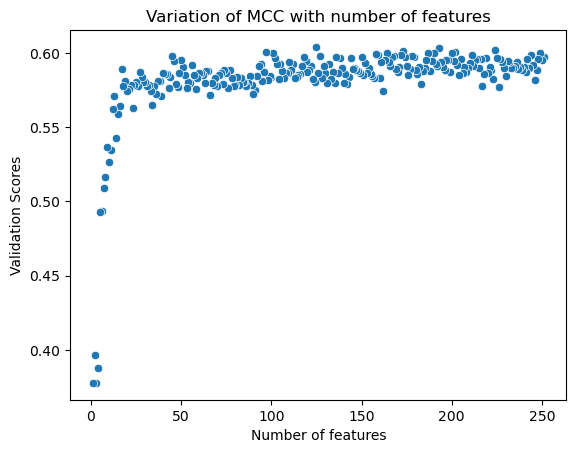

Degree 2 done
New number of features are 2022
New number of features are 2021
New number of features are 2020
New number of features are 2019
New number of features are 2018
New number of features are 2017
New number of features are 2016
New number of features are 2015
New number of features are 2014
New number of features are 2013
New number of features are 2012
New number of features are 2011
New number of features are 2010
New number of features are 2009
New number of features are 2008
New number of features are 2007
New number of features are 2006
New number of features are 2005
New number of features are 2004
New number of features are 2003
New number of features are 2002
New number of features are 2001
New number of features are 2000
New number of features are 1999
New number of features are 1998
New number of features are 1997
New number of features are 1996
New number of features are 1995
New number of features are 1994
New number of features are 1993
New number of features are

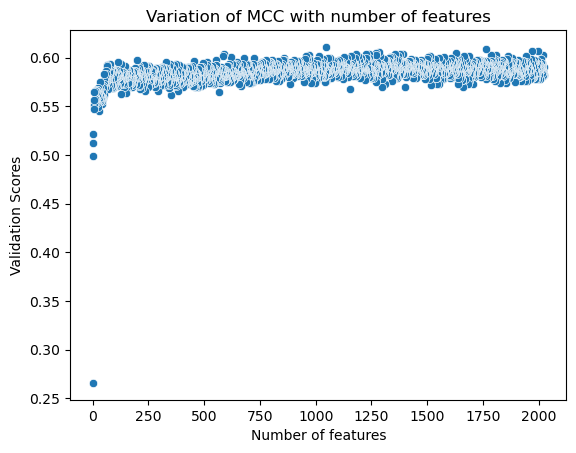

Degree 3 done


In [36]:
optimal_num_of_features=[]
best_scores_for_each_degree=[]

max_degree=3#Theres already 2024 features when degree is 3

for degree in range(1,max_degree+1):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly=poly.fit_transform(X_train_encoded)
    X_valid_poly=poly.transform(X_valid)
    max_num_of_features=X_train_poly.shape[1]
    num_of_features=X_train_poly.shape[1]-1
    rf_classifier = RandomForestClassifier(random_state=42)
    val_scores=[]
    new_X_train=X_train_poly
    new_X_valid=X_valid_poly
    full_features=list(sorted(range(1, num_of_features), reverse=True))
    
    while num_of_features>1:
        rfe = RFE(estimator=rf_classifier, n_features_to_select=num_of_features)
        rfe.fit(new_X_train, y_train)
        selected_features = rfe.support_
        #print(selected_features)
        #print(X_train_poly.shape)
        new_X_train=new_X_train[:,selected_features]
        #print(new_X_train.shape)
        #print(X_valid.shape)
        new_X_valid=new_X_valid[:,selected_features]
        rf_classifier.fit(new_X_train,y_train)
        y_pred=rf_classifier.predict(new_X_valid)
        mcc = matthews_corrcoef(y_valid, y_pred)
        val_scores.append(mcc)
        num_of_features-=1
        print(f"New number of features are {num_of_features}")
        
    sns.scatterplot(x=full_features, y=val_scores)
    # Add labels and a title
    plt.xlabel('Number of features')
    plt.ylabel('Validation Scores')
    plt.title('Variation of MCC with number of features')
    # Show the plot
    plt.show()
    
    max_index = val_scores.index(max(val_scores))
    best_number_of_features=X_train_poly.shape[1]-1-max_index
    optimal_num_of_features.append(best_number_of_features)
    best_scores_for_each_degree.append(max(val_scores))
    print(f"Degree {degree} done")
    

Lets start choosing our models, I think random forest is one good option to try out

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], # Regularization parameter 
              'penalty': ['l1', 'l2'], # Regularization type 
              'solver': ['liblinear', 'saga']} # Algorithm to use for optimization

In [ ]:
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1) 
grid_search.fit(X_train_encoded, y_train)

In [ ]:
best_params = grid_search.best_params_ 
best_model = grid_search.best_estimator_
best_model